In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules import local_eb_kernel_masked as rk
from scipy.integrate import quad
import timeit
from scipy.interpolate import interp1d

%pylab notebook
import time

from scipy.special import sph_harm as sph

from sympy.physics.quantum.spin import Rotation
from sympy import N

Populating the interactive namespace from numpy and matplotlib


In [2]:
nside=8 ; ell=arange(3*nside+1) ; npix=h.nside2npix(nside) ; print npix
maxlmax=3*nside
y=rk.real_space_queb_kernels(nside,maxlmax=3*nside,sampling=2500)

768


In [3]:
lmin=2 ; lmax=2
fl=ones(maxlmax+1,double)
fl[:lmin]=0 ; fl[lmax+1:]=0
wl=np.sqrt(double(2.*ell+1.)/(double(4.)*pi))*y.omega*double(fl)

In [241]:
rmr=zeros(h.nside2npix(nside),float)
almr0=h.map2alm(rmr,lmax=lmax,mmax=lmax)

almsize=h.Alm.getsize(maxlmax,maxlmax)
for i in range(almsize):
    l,m=h.Alm.getlm(lmax,i)
    if m==0:
        almr0[i]=complex(double(1.),double(0.))*wl[l]
    rmr0=h.alm2map(almr0,nside,lmax=lmax,mmax=lmax,verbose=False)

def return_ker(nside,theta,phi):
    almr=zeros(almsize,complex)
    almr[:]=almr0[:] 
    h.rotate_alm(almr,0.,theta*pi/double(180.),phi*pi/double(180.),lmax=lmax)
    rmr=h.alm2map(almr,nside)
    return rmr

def return_ylm(nside,l,m):
    almr=zeros(almsize,complex)
    almr[h.Alm.getidx(maxlmax,l,m)]=complex(0.5,0.)
    mr=h.alm2map(almr,nside)
    
    almr=zeros(almsize,complex)
    almr[h.Alm.getidx(maxlmax,l,m)]=complex(0.,-0.5)
    mi=h.alm2map(almr,nside)
    
    return mr,mi

def return_2ylm(nside,l,m):
    elm=zeros(almsize,complex)
    blm=zeros(almsize,complex)
    elm[h.Alm.getidx(maxlmax,l,m)]=complex(-0.5,0.)
    blm[h.Alm.getidx(maxlmax,l,m)]=complex(0.,0.5)
    mr,mi=h.alm2map_spin([elm,blm],nside,2,maxlmax)
    return mr,mi

def ana_2ylm(l,m,theta,phi,s=2):
    f=Rotation.D(l,-m,s,phi,theta,0.)
    res=N(f.doit()*sqrt((2.*l+1.)/(4.*pi))*((-1.)**m))
    return res

In [242]:
mr,mi=return_ylm(nside,ell,m)
alm=h.map2alm(mr,lmax=maxlmax)
cl=h.alm2cl(alm)

print cl[32]*(2.*ell+1.)
figure()
elll=arange(3*nside+1)
#axvline(ell,color="k")
plot(elll,(2.*elll+1)*cl)
semilogy()

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/sphtfunc.py:464: RuntimeWarning: overflow encountered in long_scalars
  return m*(2*lmax+1-m)//2+l


IndexError: index -4611686018427387904 is out of bounds for axis 1 with size 28

# Testing the Spin-0 case

In [41]:
pixnum=arange(npix)
ringnum=h.pix2ring(nside,pixnum)

#theta0=2.*pi/180. ; phi0=0.*pi/180. ; print theta0*180./pi,phi0*180./pi
#cpix=h.ang2pix(nside,theta0,phi0) ; print cpix
cpix=pixnum[ringnum==4][0]
theta,phi=h.pix2ang(nside,cpix) ; print theta*180./pi,phi*180./pi
print h.ang2pix(nside,theta,phi)
data=np.zeros(npix,float) ; data[cpix]=1.

alm=h.map2alm(data,lmax=maxlmax) #; h.almxfl(alm,fl,inplace=True)
recdata=h.alm2map(alm,nside)

5.8502670637 11.25
24
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [246]:
ell=2 ; m=2
a=sph(m,ell,phi,theta)
b=conjugate(alm[h.Alm.getidx(maxlmax,ell,m)])/y.omega
mr,mi=return_ylm(nside,ell,m)

cphi=(arctan2(imag(a),real(a))-arctan2(imag(b),real(b)))
ap=sph(2,lmax,phi+cphi,theta)

print "Synthesis:",mr[cpix],mi[cpix],(mr*mr+mi*mi)[cpix],arctan2(mi[cpix],mr[cpix])*180./pi
print "Analytical:",real(a),imag(a),real(a*conjugate(a)),arctan2(imag(a),real(a))*180./pi
print "Analysis:",real(b),imag(b),real(b*conjugate(b)),arctan2(imag(b),real(b))*180./pi
#print real(ap),imag(ap),real(ap*conjugate(ap)),arctan2(imag(ap),real(ap))*180./pi

print sqrt(real(a*conjugate(a))/real(b*conjugate(b))),(arctan2(imag(a),real(a))-arctan2(imag(b),real(b)))*180./pi

IndexError: list index out of range

In [43]:
a=sph(m,ell,phi,theta)
b=conjugate(alm[h.Alm.getidx(maxlmax,ell,m)])/y.omega
mr,mi=return_ylm(nside,ell,m)

cphi=(arctan2(imag(a),real(a))-arctan2(imag(b),real(b)))
ap=sph(2,lmax,phi+cphi,theta)

print "Synthesis:",mr[cpix],mi[cpix],(mr*mr+mi*mi)[cpix],arctan2(mi[cpix],mr[cpix])*180./pi
print "Analytical:",real(a),imag(a),real(a*conjugate(a)),arctan2(imag(a),real(a))*180./pi
print "Analysis:",real(b),imag(b),real(b*conjugate(b)),arctan2(imag(b),real(b))*180./pi
#print real(ap),imag(ap),real(ap*conjugate(ap)),arctan2(imag(ap),real(ap))*180./pi

print sqrt(real(a*conjugate(a))/real(b*conjugate(b))),(arctan2(imag(a),real(a))-arctan2(imag(b),real(b)))*180./pi

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Synthesis: 0.00370772372988 0.00153578945445 1.61058645055e-05 22.5
Analytical: 0.00370772372988 0.00153578945445 1.61058645055e-05 22.5
Analysis: 0.00370089632938 0.00147448631402 1.5870743531e-05 21.7229948223
1.0073801379 0.777005177722


# Testing the Spin-2 case

In [100]:
pixnum=arange(npix)
ringnum=h.pix2ring(nside,pixnum)

theta0=20.*pi/180. ; phi0=40.*pi/180. ; print theta0*180./pi,phi0*180./pi
cpix=h.ang2pix(nside,theta0,phi0) ; print cpix
#cpix=pixnum[ringnum==32][0]
theta,phi=h.pix2ang(nside,cpix) ; print theta*180./pi,phi*180./pi
print h.ang2pix(nside,theta,phi)


data=[np.zeros(npix,float),np.zeros(npix,float),np.zeros(npix,float)] ; data[1][cpix]=1.
alm=h.map2alm(data,lmax=maxlmax,mmax=maxlmax,pol=True) #; h.almxfl(alm,fl,inplace=True)
x2lm=vectorize(complex)((imag(alm[2][:])-real(alm[1][:])),(real(alm[2][:]+imag(alm[1][:]))))

20.0 40.0
370
20.5774535054 41.7857142857
370


In [245]:
phi

0.72929829458334494

In [101]:
ell=32 ; m=16
a=ana_2ylm(ell,m,theta,phi)
b=(x2lm[h.Alm.getidx(maxlmax,ell,m)])/y.omega
mr,mi=return_2ylm(nside,ell,m)

print "Analytical:",a
print "Synthesis:",mr[cpix],mi[cpix],(mr*mr+mi*mi)[cpix],arctan2(mi[cpix],mr[cpix])*180./pi
print "Analysis:",real(b),imag(b),real(b*conjugate(b)),arctan2(imag(b),real(b))*180./pi

Analytical: 0.0012038620811747 - 0.00150959530180915*I
Synthesis: 0.00120386208117 -0.00150959530181 3.72816188574e-06 -51.4285714286
Analysis: 0.00122288459818 -0.00148412208969 3.69806511757e-06 -50.5122133071


In [190]:
cl=h.read_cl("../../data/cl_rem3.fits")


def get_alm(cl,lmax,seed=0):
    random.seed(seed)
    almsize=h.Alm.getsize(lmax,lmax)
    ar=random.normal(size=almsize)
    ai=random.normal(size=almsize)
    alm=zeros(almsize,complex)
    for i in range(almsize):
        l,m=h.Alm.getlm(lmax,i)
        if m==0:
            alm[i]=complex(ar[i],0.)*sqrt(cl[l])
        else:
            alm[i]=complex(ar[i],ai[i])*sqrt(0.5*cl[l])
    return alm

In [236]:
nside=128 ; lmax=3*nside
almt=get_alm(cl[0],lmax,1)
alme=get_alm(cl[1]*0.01,lmax,2)
almb=get_alm(cl[2],lmax,3)
alm=[almt,alme,almb]
cld=h.alm2cl(alm)
d=h.alm2map(alm,nside,pol=True)
recd=h.alm2map(h.map2alm(d,lmax=lmax,iter=1),nside)
ralm=h.map2alm(d,lmax=lmax,pol=True)
clr=h.alm2cl(ralm)

diff=[d[0]-recd[0],d[1]-recd[1],d[2]-recd[2]]

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [237]:
cldiff=h.alm2cl(h.map2alm(diff,lmax=lmax,pol=True))

<IPython.core.display.Javascript object>


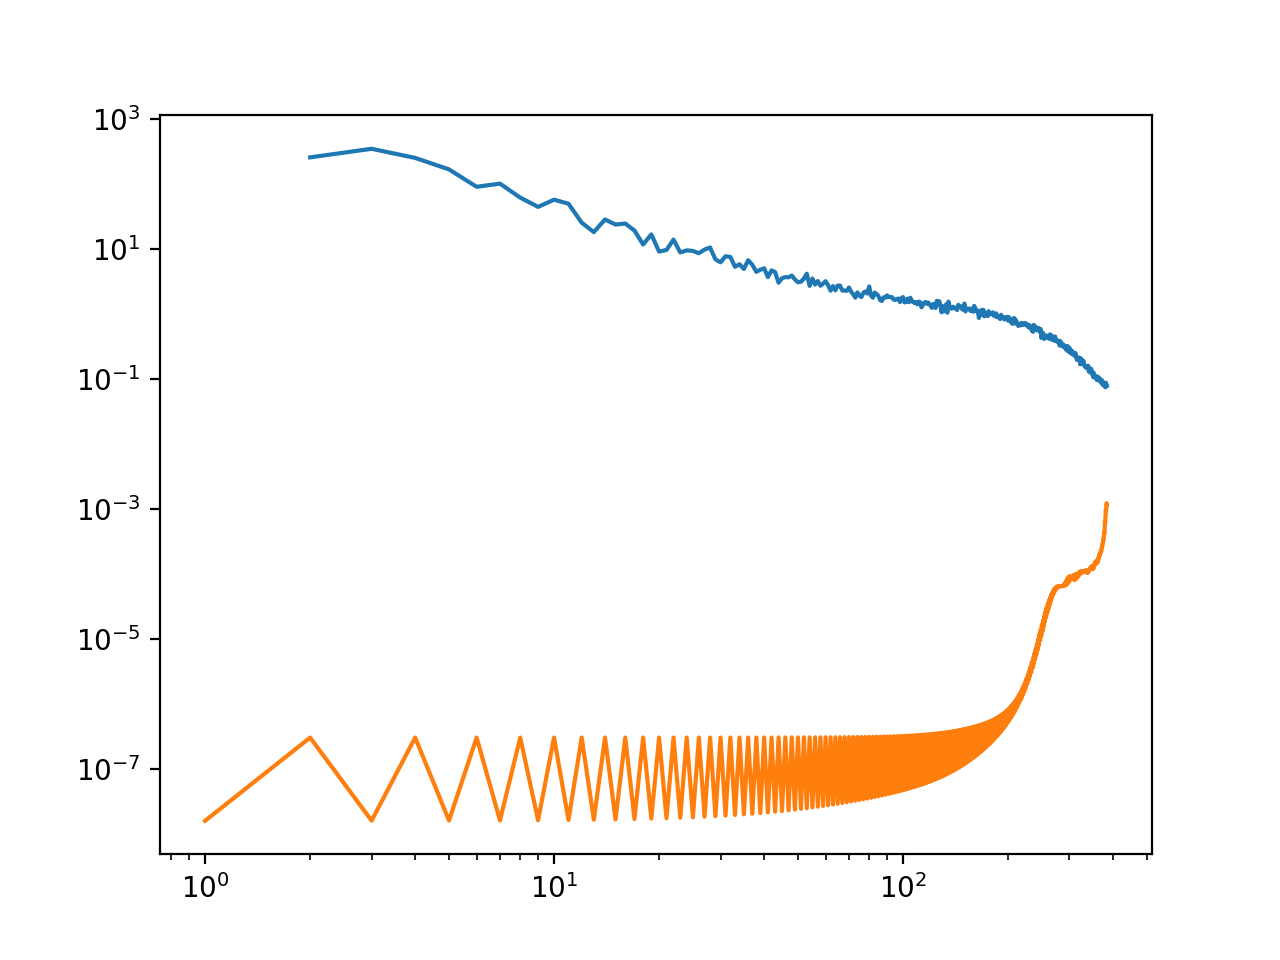

<IPython.core.display.Javascript object>


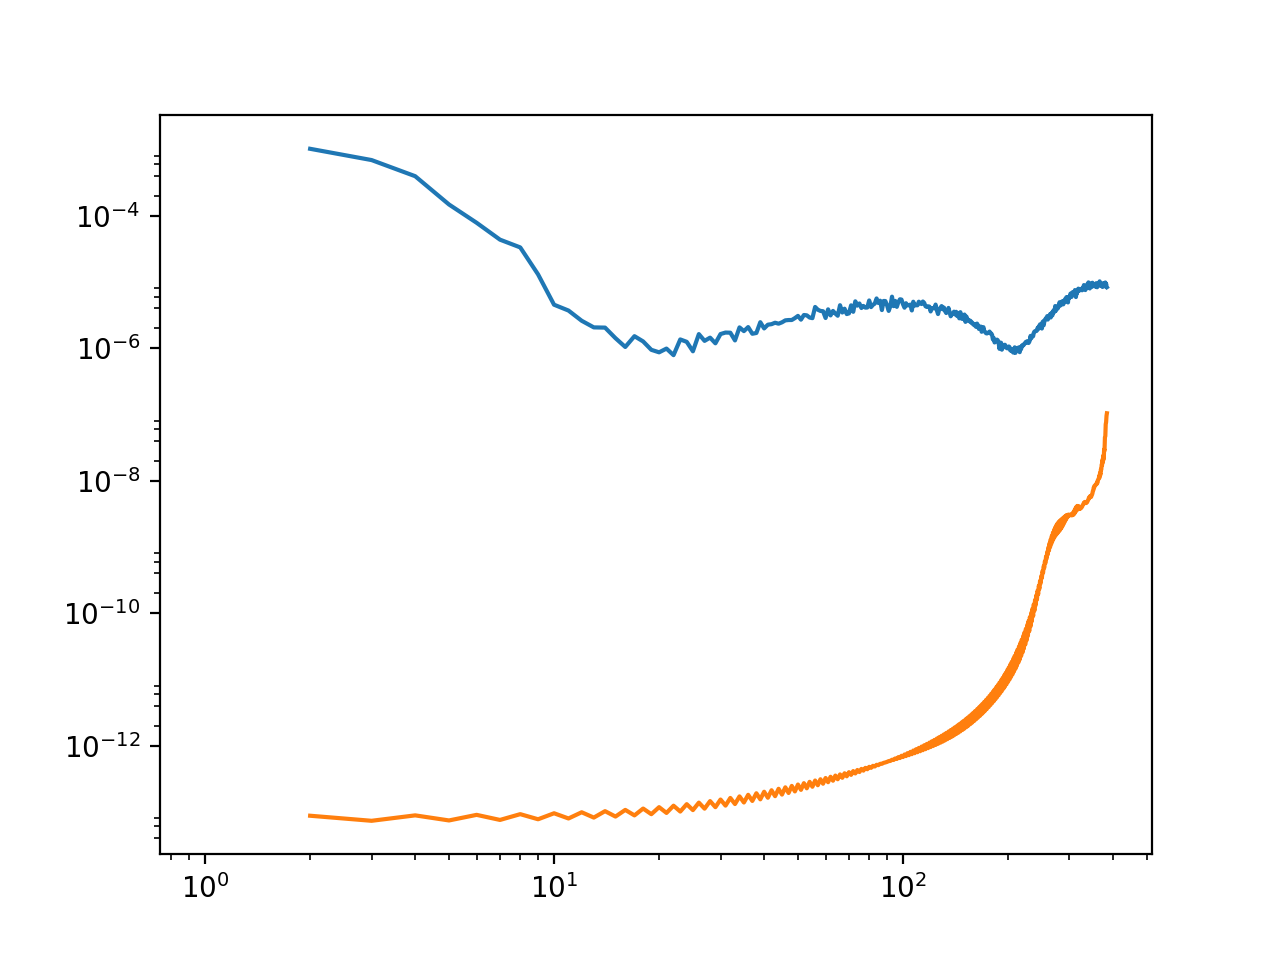

<IPython.core.display.Javascript object>


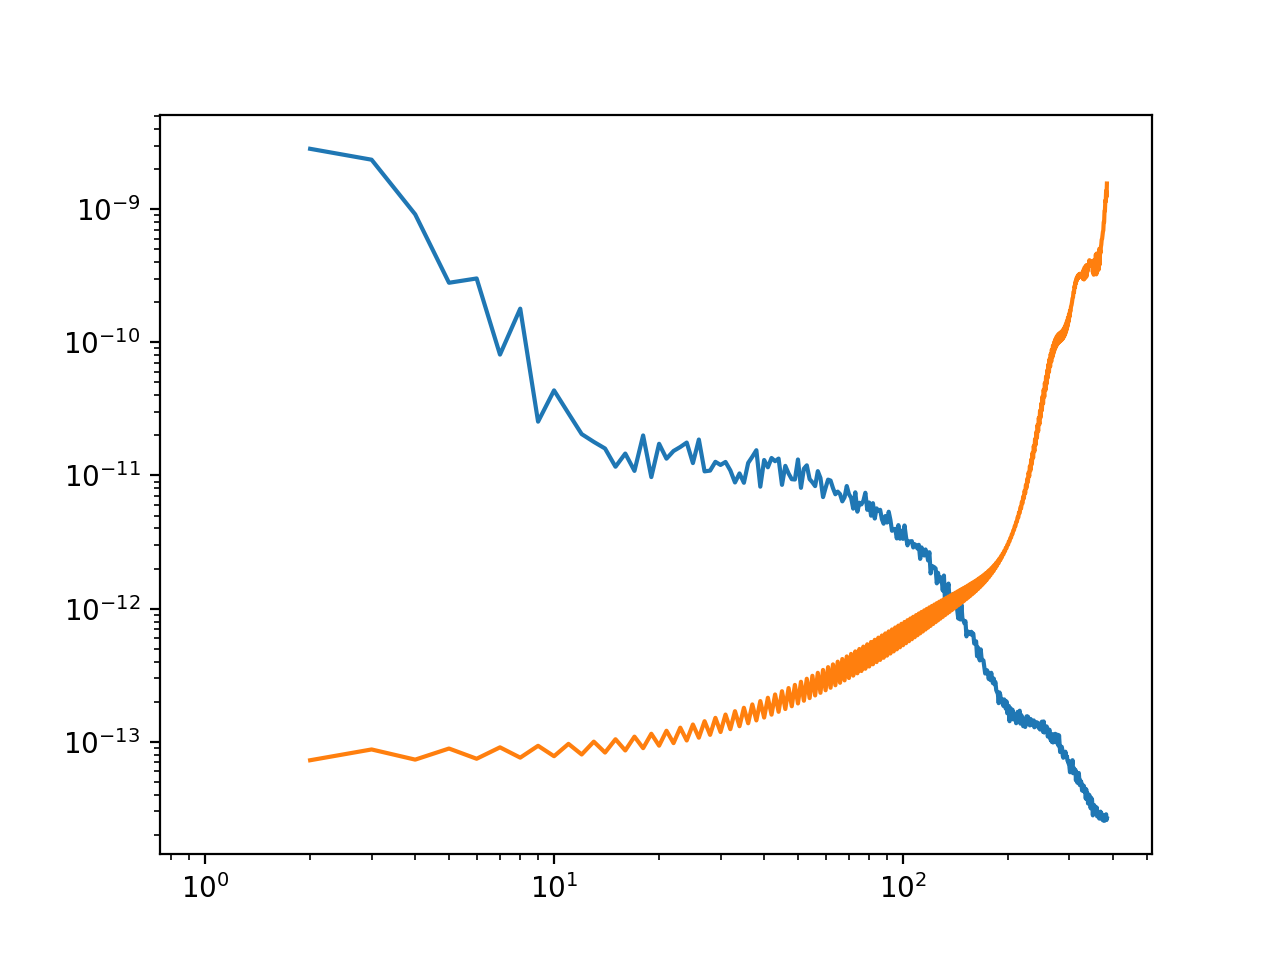

[]

In [238]:
figure()
plot(cld[0])
plot(cldiff[0])
loglog()

figure()
plot(cld[1])
plot(cldiff[1])
loglog()

figure()
plot(cld[2])
plot(cldiff[2])
loglog()

In [243]:
for l in range(4+1):
    print  l

0
1
2
3
4
